In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import math
import matplotlib.pyplot as plt

## Define Parameters

In [2]:
u = 1.1
d = 1/u
p = 0.5
q = 1-p
N =  10
K = 100 
S0 = 100
r = 0.03
dt = 1/252

In [3]:
def Payoff(price):
    return max(K-price,0)

stock_price = np.zeros((N + 1, N + 1))
stock_price[0, 0] = S0

for i in range(1, N + 1):
    stock_price[i, 0] = stock_price[i-1, 0] * u
    for j in range(1, i + 1):
        stock_price[i, j] = stock_price[i-1, j-1] * d
        
states = []
Payoff_terminal = []
for i in range(len(stock_price)):
    for j in range(len(stock_price[0])):
        if stock_price[i][j] !=0:
            states.append([j,i])
        if i == N:
            Payoff_terminal.append(Payoff(stock_price[i][j]))
states = np.array(states)

# dynamic programming for the values and early exercise policy of each node 
Optimal_val = np.zeros(len(states))
Optimal_val[-(N+1):] = Payoff_terminal 
Optimal = {}
early_exercise = {}
for i in range(len(states)):
    Optimal[str(states[i].tolist())] = Optimal_val[i]
    early_exercise[str(states[i].tolist())] = 0
for i, s in enumerate(np.flip(states)):
    if s[0]<N:      
        Optimal[str([s[1],s[0]])] = max(Payoff(stock_price[s[0]][s[1]]),(p*Optimal[str([s[1],s[0]+1])]+q*Optimal[str([s[1]+1,s[0]+1])])\
                                                    *np.exp(-dt*r))
        if Payoff(stock_price[s[0]][s[1]])==  Optimal[str([s[1],s[0]])]:
            early_exercise[str([s[1],s[0]])] = 1

## Define Environment

In [4]:
class American_easy:
    def __init__(self):
        self.reset()

    def reset(self):
        #self.state = 0
        self.state = [100,0,0.0,5,0]

    def step(self,action):
        price = self.state[0]
        t = self.state[1]
        delta = self.state[2]
        cash = self.state[3]
        out_bound = self.state[4]
        price_new = price*u if np.random.rand() < p else price*d
        num_of_d = int(-round(math.log((price_new / S0),u)) /2 +(t+1)/2)
        pay_off = Optimal[str([num_of_d,t+1])] 
        action_new = -1+action/100 # from categorical action to real action
        delta_new = delta + action_new 
        if delta_new>1:
            delta_new = 1
            out_bound = 1
        elif delta_new<-1:
            delta_new = -1
            out_bound = 1
        cash -= (delta_new-delta)*price
        cash *= np.exp(dt*r)
        reward = (pay_off-delta_new*price_new-cash)**2
        self.state = [price_new,t+1,delta_new,cash,out_bound]
        if t+1<N:
            if early_exercise[str([num_of_d,t+1])] == 1:
                return self.state,-reward,True
            else:
                return self.state,-reward,False
        else:
            return self.state,-reward,True

## Policy Gradient

### Policy Gradient with linear score function

In [5]:
def softmax(x):
    t = np.exp(x - np.max(x))
    return t / np.sum(t)

In [6]:
class ReinforceAgent_linear:
    def __init__(self, alpha, gamma):
        # set values such that initial conditions correspond to left-epsilon greedy
        self.theta = np.zeros(5)
        self.alpha = alpha
        self.gamma = gamma
        # first column - left, second - right
        x = []
        for i in actions:
            x.append([env.state[0],env.state[2],env.state[3],env.state[4],i])
        self.x = np.array(x)
        self.rewards = []
        self.actions = []

    def get_pi(self):
        h = np.dot(self.x, self.theta)
        t = np.exp(h - np.max(h))
        pmf = t / np.sum(t)
        epsilon = 0.005
        count = np.sum(pmf<=epsilon)
        deno = (1-np.sum(pmf[pmf<epsilon]))
        for i in range(len(pmf)):
            if pmf[i]<= epsilon:
                pmf[i] = epsilon
            else:
                pmf[i] = pmf[i]/deno*(1-count*epsilon)

        return pmf

    def choose_action(self, reward):
        if reward is not None:
            self.rewards.append(reward)

        pmf = self.get_pi()
        O = np.random.uniform() < np.cumsum(pmf) # a array like [false,false,false,True,True]
        idx = np.where(O == True)[0][0]
        action = actions[idx]
        #print(action)
        self.actions.append(action)

        return action

    def episode_end(self, last_reward):
        self.rewards.append(last_reward)
        # learn theta
        G = np.zeros(len(self.rewards))
        G[-1] = self.rewards[-1]
        for i in range(2, len(G) + 1):
            G[-i] = self.gamma * G[-i + 1] +self.rewards[-i]

        gamma_pow = 1

        for i in range(len(G)):
            j = np.where(actions==self.actions[i])[0][0]
            pmf = self.get_pi()
            grad_ln_pi = self.x[j] - np.dot(pmf, self.x)
            update = self.alpha * gamma_pow * G[i] * grad_ln_pi

            self.theta += update
            gamma_pow *= self.gamma

        self.rewards = []
        self.actions = []

In [7]:
num_episodes = 10000
actions = np.linspace(-1,1,1001)
env = American_easy()
gamma = 1
agent =  ReinforceAgent_linear(alpha=2e-3, gamma=gamma)

rewards = np.zeros(num_episodes)
average_reward_linear = []
for episode in range(num_episodes):
    rewards_sum = 0
    reward = None
    env.reset()

    while True:
        action = agent.choose_action(reward)
        _,reward, episode_end = env.step(action)
        rewards_sum += reward

        if episode_end:
            agent.episode_end(reward)
            break

    rewards[episode] = rewards_sum
    if episode < 100:
        avg_list = rewards[:episode+1]
    else:
        avg_list = rewards[episode-99:episode+1]
    average_reward_linear.append(np.average(avg_list))

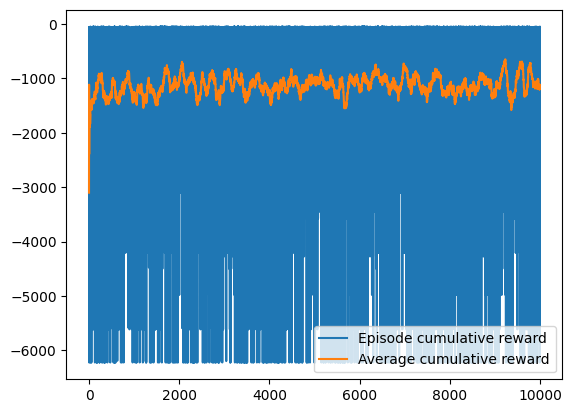

In [8]:
plt.plot(rewards,label = 'Episode cumulative reward')
plt.plot(average_reward_linear,label = 'Average cumulative reward')
plt.legend()

### Policy Gradient - Reinforce with Neural Network - Categorical

In [9]:
# define the neural network
class PolicyNet(nn.Sequential):
    def __init__(self, input_size, hidden_size, output_size):
        super(PolicyNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

In [10]:
class PolicyGradientAgent_Categorical:
    def __init__(self, input_size, hidden_size, output_size, learning_rate):
        self.policy_net = PolicyNet(input_size, hidden_size, output_size)
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=learning_rate)
    
    def get_action(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0)
        probs = self.policy_net(state)
        action_probs = torch.distributions.Categorical(probs)
        action = action_probs.sample()
        return action.item()
    
    def update_policy(self, rewards, log_probs):
        returns = []
        discount_factor = 0.99
        for i in range(len(rewards)):
            Gt = 0
            pw = 0
            for r in rewards[i:]:
                Gt = Gt + discount_factor**pw * r
                pw = pw + 1
            returns.append(Gt)
        returns = torch.tensor(returns)
        returns = (returns - returns.mean()) / (returns.std() + 1e-9)
        policy_loss = []
        for log_prob, Gt in zip(log_probs, returns):
            policy_loss.append(-log_prob * Gt)
        self.optimizer.zero_grad()
        policy_loss = torch.stack(policy_loss).sum()
        policy_loss.backward()
        self.optimizer.step()

In [11]:
env = American_easy()
input_size = np.shape(env.state)[0]
output_size = 200
agent = PolicyGradientAgent_Categorical(input_size, 128, output_size, 0.001)

# train the agent
total_reward = []
average_reward_Categorical = []
action_arr = []
for episode in range(num_episodes):
    env.reset()
    state = np.array(env.state)
    done = False
    rewards = []
    log_probs = []
    while not done:
        action = agent.get_action(state)
        action_arr.append(action)
        next_state, reward, done = env.step(action)
        rewards.append(reward)
        log_probs.append(torch.log(agent.policy_net(torch.from_numpy(state).float().unsqueeze(0))[0][action]))
        state = np.array(next_state)
    agent.update_policy(rewards, log_probs)
    total_reward.append(sum(rewards))
    
    if episode < 100:
        avg_list = total_reward[:episode+1]
    else:
        avg_list = total_reward[episode-99:episode+1]
    average_reward_Categorical.append(np.average(avg_list))
    if episode % 1000 == 0:
        print("Episode {}: {}".format(episode, sum(rewards)))

Episode 0: -2322.136559542525
Episode 1000: -1773.9907113955044
Episode 2000: -2151.3770791432116
Episode 3000: -2002.13012993595
Episode 4000: -1385.31097174685
Episode 5000: -2222.3419036151954
Episode 6000: -890.5144279284347
Episode 7000: -710.6093828719942
Episode 8000: -987.9747800735066
Episode 9000: -1512.3138741181033


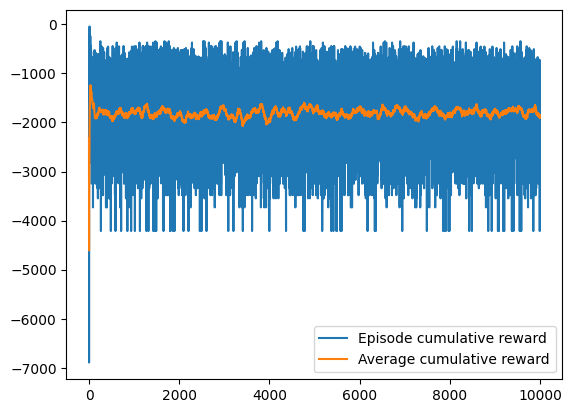

In [12]:
plt.plot(total_reward,label = 'Episode cumulative reward')
plt.plot(average_reward_Categorical,label = 'Average cumulative reward')
plt.legend()

### Policy Gradient - Reinforce with Neural Network - Pathwise derivative

In [13]:
class PolicyGradientAgent_Pairwise:
    def __init__(self, input_size, hidden_size, output_size, learning_rate):
        self.policy_net = PolicyNet(input_size, hidden_size, output_size)
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=learning_rate)
    
    def get_action(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0)
        params = self.policy_net(state)
        m = torch.distributions.normal.Normal(params[0][0],params[0][1])
        action = m.rsample()
        return action.item()
    
    def update_policy(self, rewards):
        returns = []
        discount_factor = 0.99
        for i in range(len(rewards)):
            Gt = 0
            pw = 0
            for r in rewards[i:]:
                Gt = Gt + discount_factor**pw * r
                pw = pw + 1
            returns.append(Gt)
        returns = torch.tensor(returns,requires_grad=True)
        returns = (returns - returns.mean()) / (returns.std() + 1e-9)
        policy_loss = []
        for Gt in returns:
            policy_loss.append(- Gt)
        self.optimizer.zero_grad()
        policy_loss = torch.stack(policy_loss).sum()
        policy_loss.backward()
        self.optimizer.step()

In [14]:
env = American_easy()
input_size = np.shape(env.state)[0]
output_size = 200
agent = PolicyGradientAgent_Pairwise(input_size, 128, output_size, 0.001)

# train the agent
total_reward = []
average_reward_pairwise = []
action_arr = []
for episode in range(num_episodes):
    env.reset()
    state = np.array(env.state)
    done = False
    rewards = []
    log_probs = []
    while not done:
        action = agent.get_action(state)
        action_arr.append(action)
        next_state, reward, done = env.step(action)
        rewards.append(reward)
        state = np.array(next_state)
    #print(rewards)
    agent.update_policy(rewards)
    total_reward.append(sum(rewards))
    
    if episode < 100:
        avg_list = total_reward[:episode+1]
    else:
        avg_list = total_reward[episode-99:episode+1]
    average_reward_pairwise.append(np.average(avg_list))
    if episode % 1000 == 0:
        print("Episode {}: {}".format(episode, sum(rewards)))

Episode 0: -759.8523076343007
Episode 1000: -236.78173362964827
Episode 2000: -644.6474626602983
Episode 3000: -245.66055174268567
Episode 4000: -93.60725619495267
Episode 5000: -2343.919393064849
Episode 6000: -1728.6266393181577
Episode 7000: -368.77141295291716
Episode 8000: -566.2872345117023
Episode 9000: -1122.9941364613433


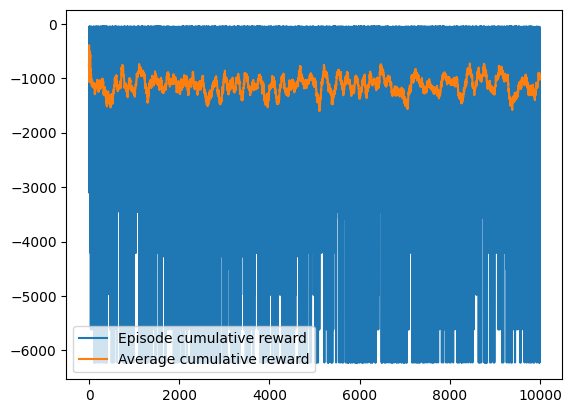

In [15]:
plt.plot(total_reward,label = 'Episode cumulative reward')
plt.plot(average_reward_pairwise,label = 'Average cumulative reward')
plt.legend()

### Policy Gradient with Baseline by Neural Network

In [16]:
# define the policy gradient agent
class PolicyGradientAgentWithBaseline:
    def __init__(self, input_size, hidden_size, output_size, learning_rate):
        self.policy_net = PolicyNet(input_size, hidden_size, output_size)
        self.baseline_net =  BaselineNet(input_size, hidden_size, output_size=1)
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=learning_rate)
        self.optimizer2 = optim.Adam(self.baseline_net.parameters(), lr=learning_rate)
        self.loss = nn.MSELoss()
    
    def get_advantage(self, returns, observations):
        values = self.baseline_net.forward(observations).detach().numpy()
        advantages = returns - values
        advantages = (advantages-torch.mean(advantages)) / np.sqrt(torch.sum(advantages**2))
        return advantages
    
    def get_action(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0)
        probs = self.policy_net(state)
        action_probs = torch.distributions.Categorical(probs)
        action = action_probs.sample()
        return action.item()
    
    def update_policy(self, rewards, log_probs, observations):
        returns = []
        discount_factor = 0.99
        for i in range(len(rewards)):
            Gt = 0
            pw = 0
            for r in rewards[i:]:
                Gt = Gt + discount_factor**pw * r
                pw = pw + 1
            returns.append(Gt)
        returns = torch.tensor(returns)
        returns = (returns - returns.mean()) / (returns.std() + 1e-9)
        observations =  torch.tensor(observations,dtype = torch.float32)
        advantages = self.get_advantage(returns, observations)
        # update baseline
        values = self.baseline_net.forward(observations)
        loss = self.loss(values.float(),torch.unsqueeze(returns, 1).float())
        self.optimizer2.zero_grad()
        loss.backward()
        self.optimizer2.step()
        
        policy_loss = []
        for log_prob, Gt,at in zip(log_probs, returns,advantages):
            policy_loss.append(-log_prob * Gt*at)
        self.optimizer.zero_grad()
        policy_loss = torch.stack(policy_loss).sum()
        policy_loss.backward()
        self.optimizer.step()

In [17]:
class BaselineNet(nn.Sequential):
    def __init__(self, input_size=5, hidden_size=128, output_size=1):
        super(BaselineNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x): 
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [18]:
env = American_easy()
input_size = np.shape(env.state)[0]
output_size = 200

In [19]:
agent = PolicyGradientAgentWithBaseline(input_size, 128, output_size, 0.001)

# train the agent
total_reward = []
average_reward_baseline = []
action_arr = []
for episode in range(num_episodes):
    env.reset()
    state = np.array(env.state)
    done = False
    rewards = []
    log_probs = []
    observations = []
    while not done:
        action = agent.get_action(state)
        action_arr.append(action)
        next_state, reward, done = env.step(action)
        rewards.append(reward)
        log_probs.append(torch.log(agent.policy_net(torch.from_numpy(state).float().unsqueeze(0))[0][action]))
        state = np.array(next_state)
        observations.append(state)
    agent.update_policy(rewards, log_probs,observations)
    total_reward.append(sum(rewards))
    
    if episode < 100:
        avg_list = total_reward[:episode+1]
    else:
        avg_list = total_reward[episode-99:episode+1]
    average_reward_baseline.append(np.average(avg_list))
    if episode % 1000 == 0:
        print("Episode {}: {}".format(episode, sum(rewards)))

C:\Users\TIM\AppData\Local\Temp\ipykernel_20420\128949960.py:35: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:233.)
  observations =  torch.tensor(observations,dtype = torch.float32)


Episode 0: -1095.9123747696244
Episode 1000: -3860.6676088781055
Episode 2000: -3324.039339806689
Episode 3000: -3535.3828408784866
Episode 4000: -4147.227974429974
Episode 5000: -1268.2475408761934
Episode 6000: -420.2048330852086
Episode 7000: -617.3171826102217
Episode 8000: -147.2897344554648
Episode 9000: -137.91024992614481


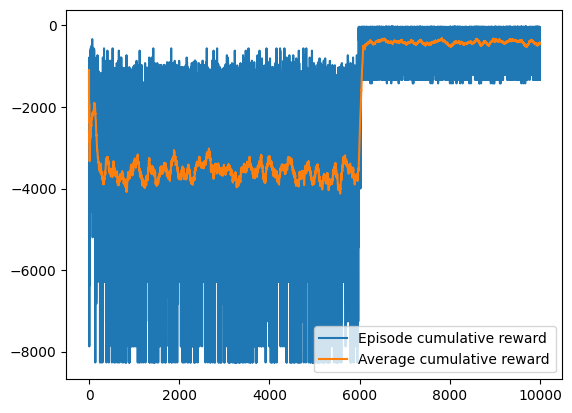

In [21]:
plt.plot(total_reward,label = 'Episode cumulative reward')
plt.plot(average_reward_baseline,label = 'Average cumulative reward')
plt.legend()

### Conclusion

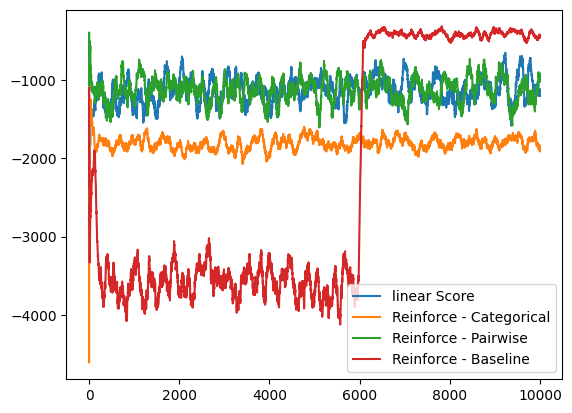

In [23]:
plt.plot(average_reward_linear,label = 'linear Score')
plt.plot(average_reward_Categorical,label = 'Reinforce - Categorical')
plt.plot(average_reward_pairwise,label = 'Reinforce - Pairwise')
plt.plot(average_reward_baseline,label = 'Reinforce - Baseline')
plt.legend()